<a href="https://colab.research.google.com/github/JoanChege/CHATBOT1/blob/main/ModelFinal9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import json
import pickle
import numpy as np
import re
import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, classification_report

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


import nltk
nltk.download('all')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [2]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

intents = json.loads(open('/content/dataset3.json').read())

docs = []
tags = []
words = []

for intent in intents['intents']:
    for pattern in intent['patterns']:

        # Normalize text
        pattern = pattern.lower()
        pattern = re.sub(r'[^a-zA-Z0-9\s]', ' ', pattern)

        # Tokenize
        tokens = word_tokenize(pattern)

        # Stop words & lemmatize
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

        # Store
        words.extend(tokens)
        docs.append((tokens, intent['tag']))

        if intent['tag'] not in tags:
            tags.append(intent['tag'])

# Additional cleaning
words = sorted(set(words))
tags = sorted(set(tags))

pickle.dump(words, open('words.pkl','wb'))
pickle.dump(tags, open('tags.pkl','wb'))

In [3]:
training = []
outputEmpty = [0] * len(tags)

for document in docs:
    bag = []
    wordPatterns = document[0]
    wordPatterns = [lemmatizer.lemmatize(word.lower()) for word in wordPatterns]
    for word in words:
        bag.append(1) if word in wordPatterns else bag.append(0)

    outputRow = list(outputEmpty)
    outputRow[tags.index(document[1])] = 1
    training.append(bag + outputRow)

random.shuffle(training)
training = np.array(training)

trainX = training[:, :len(words)]
trainY = training[:, len(words):]

In [4]:
# Assuming 'trainX' and 'trainY' are your training features and labels
training = {'features': trainX, 'labels': trainY}

# Pickle the training data
with open('training_data.pkl', 'wb') as file:
    pickle.dump(training, file)

In [5]:
# Split the data into training and testing sets
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

# Print the shapes of the datasets
print("Shapes of the datasets:")
print(f"Train set - X: {trainX.shape}, Y: {trainY.shape}")
print(f"Validation set - X: {valX.shape}, Y: {valY.shape}")
print(f"Test set - X: {testX.shape}, Y: {testY.shape}")


Shapes of the datasets:
Train set - X: (3833, 10751), Y: (3833, 318)
Validation set - X: (959, 10751), Y: (959, 318)
Test set - X: (1199, 10751), Y: (1199, 318)


In [6]:
# Assuming trainX has 10751 features
num_features = trainX.shape[1]

# Slice Y arrays to match the number of features in X
trainY = trainY[:, :num_features]
valY = valY[:, :num_features]
testY = testY[:, :num_features]

# Print the shapes after slicing
print("Shapes of the datasets after slicing:")
print(f"Train set - X: {trainX.shape}, Y: {trainY.shape}")
print(f"Validation set - X: {valX.shape}, Y: {valY.shape}")
print(f"Test set - X: {testX.shape}, Y: {testY.shape}")


Shapes of the datasets after slicing:
Train set - X: (3833, 10751), Y: (3833, 318)
Validation set - X: (959, 10751), Y: (959, 318)
Test set - X: (1199, 10751), Y: (1199, 318)


In [7]:
#build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(words), output_dim=100, input_length=len(trainX[0])))
model.add(LSTM(units=256, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(len(trainY[0]), activation='softmax'))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10751, 100)        1075100   
                                                                 
 lstm (LSTM)                 (None, 10751, 256)        365568    
                                                                 
 dropout (Dropout)           (None, 10751, 256)        0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Training with early stopping callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [11]:
model_hist = model.fit(trainX, trainY, epochs=30, batch_size=64, verbose=1, validation_data=(valX, valY), callbacks=[early_stop])

Epoch 1/30
60/60 [==============================] - 81s 1s/step - loss: 4.9256 - accuracy: 0.8411 - val_loss: 2.2072 - val_accuracy: 0.8916
Epoch 2/30
60/60 [==============================] - 82s 1s/step - loss: 1.7740 - accuracy: 0.8996 - val_loss: 1.4115 - val_accuracy: 0.8916
Epoch 3/30
60/60 [==============================] - 82s 1s/step - loss: 1.3378 - accuracy: 0.8996 - val_loss: 1.2779 - val_accuracy: 0.8916
Epoch 4/30
60/60 [==============================] - 82s 1s/step - loss: 1.1922 - accuracy: 0.8996 - val_loss: 1.2329 - val_accuracy: 0.8916
Epoch 5/30
60/60 [==============================] - 82s 1s/step - loss: 1.1294 - accuracy: 0.8996 - val_loss: 1.1935 - val_accuracy: 0.8916
Epoch 6/30
60/60 [==============================] - 83s 1s/step - loss: 1.0671 - accuracy: 0.8996 - val_loss: 1.1679 - val_accuracy: 0.8916
Epoch 7/30
60/60 [==============================] - 83s 1s/step - loss: 1.0420 - accuracy: 0.8996 - val_loss: 1.1715 - val_accuracy: 0.8916
Epoch 8/30
60/60 [==

In [12]:
model.save('chatbot_model.h5')
print('Done')

Done


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


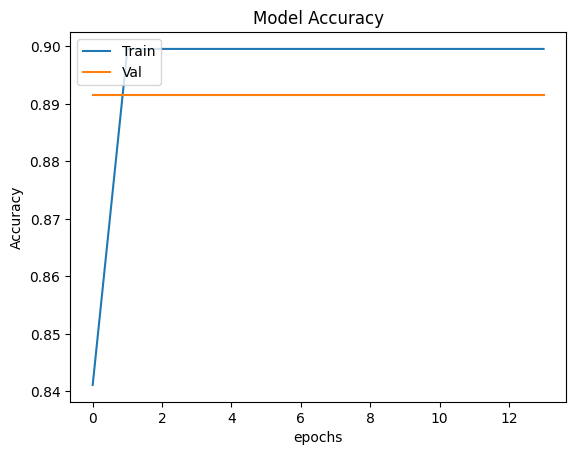

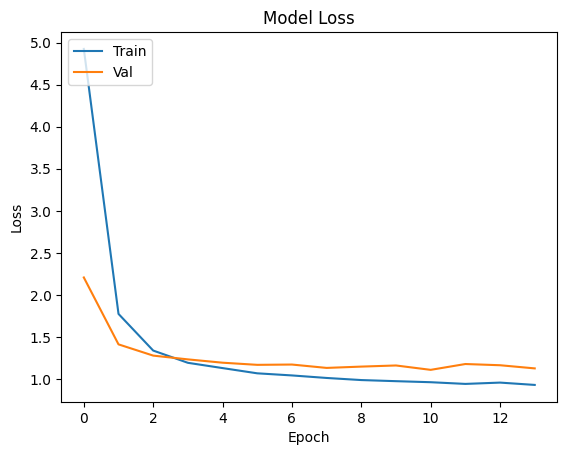

In [13]:
def plot(history):
    #Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot(model_hist)

In [14]:
# Evaluate the model on the test dataset
correct = 0
total = len(testX)
for i, test in enumerate(testX):
    predicted = model.predict(np.array([test]))[0]
    label = np.argmax(testY[i])
    if np.argmax(predicted) == label:
        correct += 1

print("Accuracy:", correct/total)



1/1 [==============================] - 0s 214ms/step
Accuracy: 0.8824020016680567


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  confusion_matrix, classification_report


# Assuming valX and valY are your validation data
val_predictions = model.predict(valX)

# Convert predictions to labels
val_predicted_labels = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(valY, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_true_labels, val_predicted_labels)
precision = precision_score(val_true_labels, val_predicted_labels, average='weighted')
recall = recall_score(val_true_labels, val_predicted_labels, average='weighted')
f1 = f1_score(val_true_labels, val_predicted_labels, average='weighted')
confusion_mat = confusion_matrix(val_true_labels, val_predicted_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print('Confusion Matrix:')
print(confusion_mat)

# Classification report
#print('Classification Report:')
#print(classification_report(val_true_labels, val_predicted_labels))


30/30 [==============================] - 10s 319ms/step
Accuracy: 0.8916
Precision: 0.7949
Recall: 0.8916
F1 Score: 0.8404
Confusion Matrix:
[[  0   8   0 ...   0   0   0]
 [  0 855   0 ...   0   0   0]
 [  0   2   0 ...   0   0   0]
 ...
 [  0   1   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  0   1   0 ...   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# Function to preprocess and vectorize user input
def preprocess_and_vectorize(text, tokenizer):
    processed_text = text.lower()
    tokens = word_tokenize(processed_text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    sequence = tokenizer.texts_to_sequences([tokens])
    padded_sequence = pad_sequences(sequence, maxlen=len(words))
    return padded_sequence

# Load stopwords, lemmatizer, and intents
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
intents = json.loads(open('/content/dataset3.json').read())

# Load words and tags
words = pickle.load(open('words.pkl', 'rb'))
tags = pickle.load(open('tags.pkl', 'rb'))

# Load the trained model
model = tf.keras.models.load_model('chatbot_model.h5')  # Replace with the actual path to your trained model

# Load the tokenizer used during training
with open('training_data.pkl', 'rb') as handle:
    training_data = pickle.load(handle)

# Extract the tokenizer from the training data
tokenizer = Tokenizer()
tokenizer.word_index = training_data['tokenizer_word_index']

# User input
user_input = input("Enter your text: ")

# Preprocess and vectorize user input
processed_input = preprocess_and_vectorize(user_input, tokenizer)

# Make predictions using the trained model
predicted_output = model.predict(processed_input)[0]
predicted_label = np.argmax(predicted_output)

# Print the predicted label
print("Predicted Label:", predicted_label)


KeyError: 'tokenizer_word_index'